In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as pmimage
import numpy as np
from scipy import io, linalg
from random import shuffle
import math
import time

Problem 1

PCA and low dimensional PCA

In [2]:
data_path = 'material/face.mat'
face_mat = io.loadmat(data_path)
X = np.array(face_mat['X'])
L = np.array(face_mat['l']).ravel()
total_num = np.shape(X)[1]
train_idx = np.array(range(total_num)) % 10 < 8
test_idx = np.array(range(total_num)) % 10 >= 8
shuffle(train_idx)
train_num = total_num * 8 // 10
test_num = total_num - train_num
train_X = X[:, train_idx]
train_L = L[train_idx]
test_X = X[:, test_idx]
test_L = L[test_idx]

In [3]:
def pca(normed_features):
    S = normed_features @ normed_features.transpose() /np.shape(normed_features)[1]
    v, u = np.linalg.eig(S)
    v = v.real
    u = u.real
    idx = np.argsort(v)[::-1]
    return v[idx], u[:, idx]

def low_pca(normed_features):
    S = normed_features.transpose() @ normed_features / np.shape(normed_features)[1]
    val, vec = np.linalg.eig(S)
    vec = normed_features @ vec
    vec = vec / np.sqrt(np.sum(np.power(vec, 2), axis=0))
    idx = np.argsort(val)[::-1]
    return val[idx], vec[:, idx]

In [4]:
mean_feat = np.mean(train_X, axis=1)
A = train_X - mean_feat[:, None]
start = time.time()
val_1, u1 = pca(A)
middle = time.time()
val_2, u2 = low_pca(A)
end = time.time()
print(middle-start, end-middle)


13.280109167098999 1.4973149299621582


original nonzero eig_val is 1497
 reduced eig_val is 416


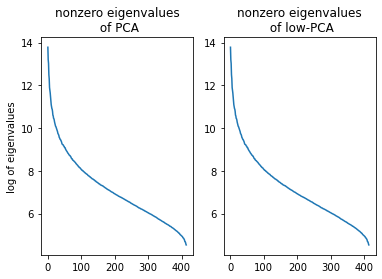

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.log(val_1[:415]))
ax2.plot(np.log(val_2[:415]))
ax1.set_title('nonzero eigenvalues\n of PCA')
ax1.set_ylabel('log of eigenvalues')
ax2.set_title('nonzero eigenvalues\n of low-PCA')
print("original nonzero eig_val is {}\n reduced eig_val is {}".format(
    np.count_nonzero(val_1 > 0), np.count_nonzero(val_2 > 0)
))
plt.savefig('report(latex)/fig1.png', dpi=300)

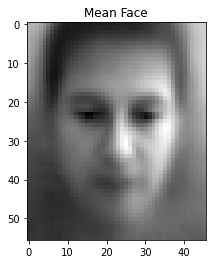

In [6]:
mean_face = mean_feat.reshape((-1, 56)).transpose()
plt.imshow(mean_face, cmap='gray')
plt.title('Mean Face');

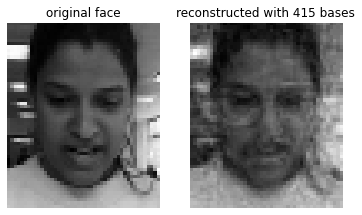

15.686850263498815


In [53]:
n = 415
sample = test_X[:, 51]
a = (sample - mean_feat) @ u2[:, :n]
recon = mean_feat + u2[:, :n] @ a
recon_fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample.reshape((-1, 56)).transpose(), cmap='gray')
ax2.imshow(recon.reshape((-1, 56)).transpose(), cmap='gray')
ax1.set_title('original face')
ax2.set_title('reconstructed with {} bases'.format(n))
ax1.axis('off')
ax2.axis('off')
plt.savefig('report(latex)/fig3.png', dpi=300)
plt.show()
print(math.sqrt(np.mean((recon - sample)**2)))

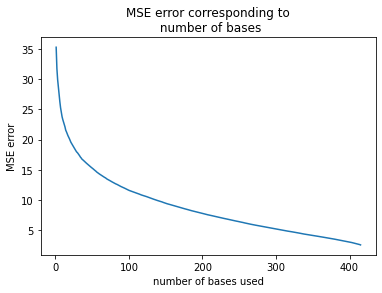

In [38]:
acc = []
de_meaned_test_X = test_X - mean_feat[:, None]
for i in range(1, 416):
    a = de_meaned_test_X.transpose() @ u2[:, :i]
    recon = mean_feat[:, None] + u2[:, :i] @ a.transpose()
    acc.append(np.sqrt(np.mean((recon - test_X)**2, axis=0)))
acc = np.array(acc)
fig = plt.figure()
ax1 = fig.add_subplot(111)
X = np.arange(1, 416)
ax1.plot(X, np.mean(acc, axis=1))
ax1.set_ylabel('MSE error')
ax1.set_xlabel('number of bases used')
plt.title('MSE error corresponding to\n number of bases')
plt.savefig('report(latex)/fig2.png', dpi=300)

Problem 2

Face recognition with PCA and PCA-LDA

In [9]:
from sklearn.neighbors import KNeighborsClassifier

classification with pca

In [10]:
m = 50
pcaed_train = u2[:, :m].transpose() @ (train_X - mean_feat[:, None])
clf = KNeighborsClassifier()
clf.fit(pcaed_train.transpose(), train_L.ravel())
pcaed_test = u2[:, :m].transpose() @ (test_X - mean_feat[:, None])
predict_batch_pca = clf.predict(pcaed_test.transpose())
print("accuracy of pca is {}".format(np.count_nonzero(predict_batch_pca == test_L) / (test_num)))

accuracy of pca is 0.6923076923076923


In [22]:
pr = []
for i in range(1, 416):
    pcaed_train = u2[:, :i].transpose() @ (train_X - mean_feat[:, None])
    clf = KNeighborsClassifier()
    clf.fit(pcaed_train.transpose(), train_L.ravel())
    pcaed_test = u2[:, :i].transpose() @ (test_X - mean_feat[:, None])
    predict_batch_pca = clf.predict(pcaed_test.transpose())
    pr.append(np.count_nonzero(predict_batch_pca == test_L) / (test_num))

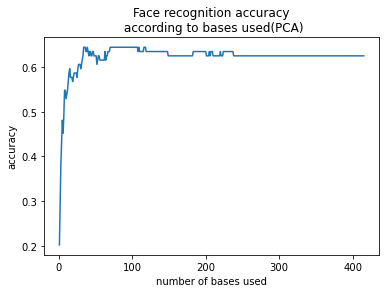

In [42]:
pr = np.array(pr)
fig = plt.figure()
ax = fig.add_subplot(111)
X = np.arange(1, 416)
ax.plot(X, pr)
ax.set_xlabel('number of bases used')
ax.set_ylabel('accuracy')
plt.title('Face recognition accuracy\n according to bases used(PCA)')
plt.savefig('report(latex)/fig9.png', dpi=300)

classification with pca-lda

In [18]:
mpca = 50
num_class = 52
start = time.time()
feats = train_X - mean_feat[:, None]
labels = train_L
mean_per_class = np.array([np.mean(feats[:, labels == i], axis=1) for i in range(1, num_class + 1)])
n = np.shape(feats)[0]
scatter_b = np.zeros((n, n))
scatter_w = np.zeros((n, n))
for i in range(1, num_class + 1):
    temp = mean_per_class[i - 1] - mean_feat
    scatter_b += np.count_nonzero(train_L == i) * temp[:, None] @ temp.reshape((1, -1))
for i in range(train_num):
    temp = feats[:, i] - mean_per_class[train_L[i] - 1].transpose()
    scatter_w += temp[:, None] @ temp[:, None].reshape((1, -1))

def pca_lda(w_pca, m_pca):
    w = w_pca[:, :m_pca]
    val, vec = np.linalg.eig(np.linalg.inv(w.transpose() @ scatter_w @ w) @ (w.transpose() @ scatter_b @ w))
    val = val.real
    vec = vec.real
    idx = np.argsort(val)[::-1]
    return val[idx], vec[:, idx]

lda_val, lda_vec = pca_lda(u2, mpca)
end = time.time()
print(end - start)

22.189696073532104


In [43]:
print(np.linalg.matrix_rank(scatter_b))
print(np.linalg.matrix_rank(scatter_w))

52
364


In [19]:
mlda = 10
pca_train_pcalda = u2[:, :mpca].transpose() @ (train_X - mean_feat[:, None])
mean_pca_pcalda = np.mean(pca_train_pcalda, axis=1)
pca_test_pcalda = u2[:, :mpca].transpose() @ (test_X - mean_feat[:, None])
pca_lda_train = lda_vec[:, :mlda].transpose() @ (pca_train_pcalda - mean_pca_pcalda[:, None])
clf_pca_lda = KNeighborsClassifier()
clf_pca_lda.fit(pca_lda_train.transpose(), train_L)
pca_lda_test = lda_vec[:, :mlda].transpose() @ (pca_test_pcalda - np.mean(pca_test_pcalda, axis=1)[:, None])
predict_pca_lda = clf_pca_lda.predict(pca_lda_test.transpose())
print("accuracy of pca-lda is {}".format(np.count_nonzero(predict_pca_lda == test_L) / test_num))


accuracy of pca-lda is 0.8653846153846154


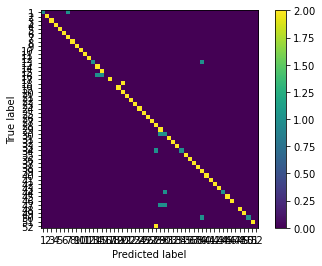

In [20]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_pca_lda, pca_lda_test.transpose(), test_L, include_values=False)



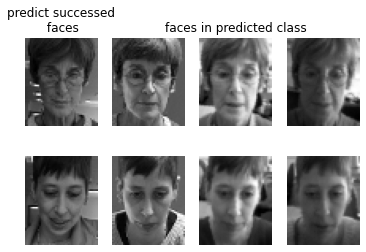

In [65]:
wrong = test_X[:, (19, 20)]
predicted_class_1 = train_X[:, train_L == 10]
predicted_class_2 = train_X[:, train_L == 11]
recon_fig, ax_list = plt.subplots(2, 4)
for i in range(np.shape(ax_list)[0]):
    for j in range(np.shape(ax_list)[1]):
        _ax = ax_list[i, j]
        _ax.axis('off')
        if j == 0:
            _ax.imshow(wrong[:, i].reshape((-1, 56)).transpose(), cmap='gray')
        elif i == 0:
            _ax.imshow(predicted_class_1[:, j].reshape((-1, 56)).transpose(), cmap='gray')
        else:
            _ax.imshow(predicted_class_2[:, j].reshape((-1, 56)).transpose(), cmap='gray')

ax_list[0, 2].set_title('faces in predicted class')
ax_list[0, 0].set_title('predict successed\n faces')

#
# ax4.imshow(wrong.reshape((-1, 56)).transpose(), cmap='gray')
# ax1.imshow(predicted_class[:, 0].reshape((-1, 56)).transpose(), cmap='gray')
# ax2.imshow(predicted_class[:, 1].reshape((-1, 56)).transpose(), cmap='gray')
# ax3.imshow(predicted_class[:, 2].reshape((-1, 56)).transpose(), cmap='gray')
# ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')
# ax4.axis('off')
plt.savefig('report(latex)/fig11.png', dpi=300)
# plt.show()

In [74]:
accuracy = np.zeros((416, 416))
for i in range(1, 416):
    lda_val, lda_vec = pca_lda(u2, i)
    for j in range(1, i+1):
        pca_train_pcalda = u2[:, :i].transpose() @ (train_X - mean_feat[:, None])
        mean_pca_pcalda = np.mean(pca_train_pcalda, axis=1)
        pca_test_pcalda = u2[:, :i].transpose() @ (test_X - mean_feat[:, None])
        pca_lda_train = lda_vec[:, :j].transpose() @ (pca_train_pcalda - mean_pca_pcalda[:, None])
        clf_pca_lda = KNeighborsClassifier()
        clf_pca_lda.fit(pca_lda_train.transpose(), train_L)
        pca_lda_test = lda_vec[:, :j].transpose() @ (pca_test_pcalda - np.mean(pca_test_pcalda, axis=1)[:, None])
        predict_pca_lda = clf_pca_lda.predict(pca_lda_test.transpose())
        accuracy[i, j] = np.count_nonzero(predict_pca_lda == test_L) / test_num

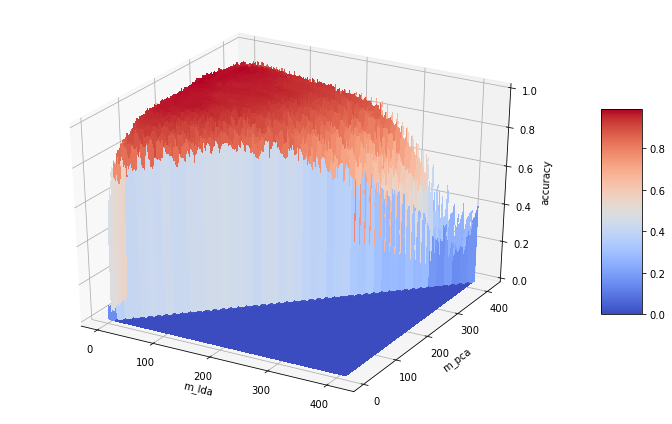

364 31


In [86]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X = np.arange(1, 416)
Y = np.arange(1, 416)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X,Y,accuracy[1:, 1:],cmap='coolwarm',linewidth=0,antialiased=False)
ax.set_xlabel('m_lda')
ax.set_ylabel('m_pca')
ax.set_zlabel('accuracy')
fig.colorbar(surf,shrink=0.5,aspect=5)
fig.tight_layout()
plt.savefig('report(latex)/fig7.png', dpi=300)
plt.show()
print(np.argmax(accuracy) // 416, np.argmax(accuracy) % 416)

Problem 3

Incremental PCA

In [13]:
train_subset1 = train_X[:, 0::4]
train_subset2 = train_X[:, 1::4]
train_subset3 = train_X[:, 2::4]
train_subset4 = train_X[:, 3::4]


In [25]:
i_pca_m = 35
mu_s1 = np.mean(train_subset1, axis=1)[:, None]
mu_s2 = np.mean(train_subset2, axis=1)[:, None]
mu_s3 = np.mean(train_subset3, axis=1)[:, None]
mu_s4 = np.mean(train_subset4, axis=1)[:, None]
start = time.time()
val_s1, u_s1 = low_pca(train_subset1 - mu_s1)
val_s2, u_s2 = low_pca(train_subset2 - mu_s2)
val_s3, u_s3 = low_pca(train_subset3 - mu_s3)
val_s4, u_s4 = low_pca(train_subset4 - mu_s4)
print(time.time() - start)
pca_s1 = (mu_s1, np.shape(train_subset1)[1], u_s1[:, :i_pca_m], val_s1[:i_pca_m])
pca_s2 = (mu_s2, np.shape(train_subset2)[1], u_s2[:, :i_pca_m], val_s2[:i_pca_m])
pca_s3 = (mu_s3, np.shape(train_subset3)[1], u_s3[:, :i_pca_m], val_s3[:i_pca_m])
pca_s4 = (mu_s4, np.shape(train_subset4)[1], u_s4[:, :i_pca_m], val_s4[:i_pca_m])

0.2912709712982178


In [15]:
def gram_schmidt(vec_1, vec_2):
    if np.shape(vec_2)[1] == 0:
        return vec_1
    q = vec_2[:, 0]
    mul = q @ vec_1
    q = q - np.sum(mul * vec_1, axis=1)
    if np.count_nonzero(q) == 0:
        return gram_schmidt(vec_1, vec_2[:, 1:])
    q = q / np.linalg.norm(q)
    return gram_schmidt(np.concatenate((vec_1, q[:, None]), axis=1), vec_2[:, 1:])

In [26]:
def incremental_pca(pca1, pca2):
    mu1, N1, vec1, val1 = pca1
    mu2, N2, vec2, val2 = pca2
    N = N1 + N2
    mu = (N1 * mu1 + N2 * mu2) / N
    S1 = vec1 @ np.diag(val1) @ vec1.transpose()
    S2 = vec2 @ np.diag(val2) @ vec2.transpose()
    S = S1 * N1 / N + S2 * N2 / N + N1 * N2 / (N**2) * (mu1 - mu2) @ (mu1 - mu2).transpose()
    phi = gram_schmidt(gram_schmidt(vec1, vec2), (mu1 - mu2))
    start = time.time()
    val, r = np.linalg.eig(phi.transpose() @ S @ phi)
    print(time.time() - start)
    return mu, N, phi @ r, val

In [27]:
i_pca_1 = incremental_pca(pca_s1, pca_s2)
i_pca_2 = incremental_pca(i_pca_1, pca_s3)
i_pca_3 = incremental_pca(i_pca_2, pca_s4)
_, _, i_pca_vec, i_pca_val = i_pca_3

0.042883872985839844
0.036911725997924805
0.055850982666015625


In [31]:

i_pca_train = u_s1[:, :35].transpose() @ (train_X - mean_feat[:, None])
clf_ipca = KNeighborsClassifier()
clf_ipca.fit(i_pca_train.transpose(), train_L.ravel())
i_pca_test = u_s1[:, :35].transpose() @ (test_X - mean_feat[:, None])
predict_i_pca = clf_ipca.predict(i_pca_test.transpose())
print("accuracy of incremental pca is {}".format(np.count_nonzero(predict_i_pca == test_L) / (test_num)))


accuracy of incremental pca is 0.6153846153846154


22.83938152703967


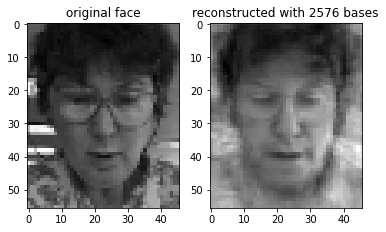

In [35]:
import math
sample = test_X[:, 0]
a = (sample - mean_feat) @ u_s1[:, :50]
recon = mean_feat + np.sum(u_s1[:, :50] * a, axis=1)
recon_fig_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample.reshape((-1, 56)).transpose(), cmap='gray')
ax2.imshow(recon.reshape((-1, 56)).transpose(), cmap='gray')
ax1.set_title('original face')
ax2.set_title('reconstructed with {} bases'.format(n))
print(math.sqrt(np.mean((recon - sample)**2)))

In [ ]:
error= []
for i in range(1, 80):
    a = (sample - mean_feat) @ i_pca_vec[:, :i]
    recon = mean_feat + np.sum(i_pca_vec[:, :i] * a, axis=1)
    error.append(math.sqrt(np.mean((recon - sample)**2)))
error = np.array(error)
plt.plot(error)
plt.show()

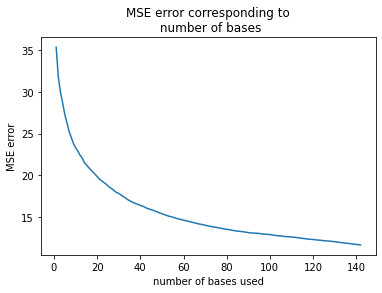

In [33]:
acc = []
de_meaned_test_X = test_X - mean_feat[:, None]
for i in range(1, 143):
    a = de_meaned_test_X.transpose() @ i_pca_vec[:, :i]
    recon = mean_feat[:, None] + i_pca_vec[:, :i] @ a.transpose()
    acc.append(np.sqrt(np.mean((recon - test_X)**2, axis=0)))
acc = np.array(acc)
fig = plt.figure()
ax1 = fig.add_subplot(111)
X = np.arange(1, 143)
ax1.plot(X, np.mean(acc, axis=1))
ax1.set_ylabel('MSE error')
ax1.set_xlabel('number of bases used')
plt.title('MSE error corresponding to\n number of bases')
plt.savefig('report(latex)/fig8.png', dpi=300)